In [3]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import math
import pyflagser
import statistics
import sys
import pickle
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

In [4]:
G=nx.read_gml("123 Bus/123busEx.gml")
A = nx.to_numpy_array(G)
N=list(G.nodes)
E=list(G.edges)
with open('123 Bus/fullanomalydataset.pkl', 'rb') as g:
    P0Data = pickle.load(g)

In [ ]:
A = nx.to_numpy_array(G)
print(A)

In [ ]:
N=list(G.nodes)
print(N)
print(len(N))
E=list(G.edges)
print(E)
print(len(E))

In [ ]:
import pickle
with open('Fully Observable/fullanomalydataset.pkl', 'rb') as g:
    P0Data = pickle.load(g)

In [5]:
N_Senario=len(P0Data)
Class=[]
for i in range(len(P0Data)):
    Class.append(P0Data[i]["Anomalous"])
print(len(Class))
i=0
l=0
m=0
while i < len(Class):
    if Class[i] == 'No':
        l=l+1
        Class[i] = 0
    if Class[i] == 'Yes':
        m=m+1
        Class[i] = 1
    i += 1
#print(Class)
print(l)
print(m)

500
251
249


In [ ]:
N_Senario=len(P0Data)
print(N_Senario)

In [8]:
def Make_Sum(Array):
    one_dim_array = []

    # Iterate through each row of the 2D array
    for row in Array:
        # Iterate through each element of the row
        for i, element in enumerate(row):
            # If the one-dimensional array is not large enough, extend it
            if len(one_dim_array) <= i:
                one_dim_array.append(element)
            else:
                # Add the element to the corresponding index of the one-dimensional array
                one_dim_array[i] += element
    return one_dim_array

In [9]:
def TimeSeries_Fe(TS_voltage, TS_branchFlow, F_voltage,F_Flow):
    betti_0=[]
    for k in range(len(TS_voltage)):
        fec=[]
        AverageVoltage=[]
        Voltage=TS_voltage[k]
        for y in Voltage:
            AverageVoltage.append(Average(list(y)))
        #AverageVoltage = [i * 100 for i in AverageVoltage]
        BranchFlow=[]
        Branch_Flow=TS_branchFlow[k]
        for j  in range(len(Branch_Flow)):
            BranchFlow.append(Branch_Flow[j][0])

        for p in range(len(F_voltage)):
            Active_node_v=np.where(np.array(AverageVoltage) > F_voltage[p])[0].tolist()
            for q in range(len(F_Flow)):
                #if AverageVoltage[p]> F_voltage[p] and BranchFlow[q]> F_Flow[q]:
                #n_active = np.where(np.array(AverageVoltage) > F_voltage[p])[0].tolist()
                n_active=Active_node_v.copy()
                #print(n_active)
                G = nx.DiGraph()
                G.add_nodes_from(n_active)
                indices = np.where(np.array(BranchFlow) > F_Flow[q])[0].tolist()
                for s in indices:
                    a=int(N.index(E[s][0]))
                    b=int(N.index(E[s][1]))
                    if a in n_active and b in n_active:
                        G.add_edge(a, b)
                    #n_active.append(int(N.index(E[s][0])))
                    #n_active.append(int(N.index(E[s][1])))
                #Active_node=np.unique(n_active)
                #print(G.edges())
                if (len(n_active)==0):
                    fec.append(0)
                else:
                    #b=A[Active_node,:][:,Active_node]
                    Adj = nx.to_numpy_array(G)
                    my_flag=pyflagser.flagser_unweighted(Adj, min_dimension=0, max_dimension=2, directed=False, coeff=2, approximation=None)
                    x = my_flag["betti"]
                    fec.append(x[0])
                n_active.clear()
            Active_node_v.clear()
        betti_0.append(fec)
    return betti_0


In [10]:
F_Flow=[100,90,75,50,25,10,5,0]
F_voltage=[1.4,1.3,1.2,1.1,1.0,0.99,0.98,0.97,0.96,0.95,0.94,0.92,0.90,0.89,0.88,0.87,0.86,0.85]
Betti_0=[]
#N_Senario=len(P0Data)
N_Senario=300
for i in range(N_Senario):
    print("\rProcessing file {} ({}%)".format(i, 100*i//(N_Senario-1)), end='', flush=True)
    TimeSeries_Voltage=P0Data[i]["TimeSeries_Voltage"]
    TimeSeries_Branch_Flow=P0Data[i]["BranchFlow"]
    betti=TimeSeries_Fe(TimeSeries_Voltage,TimeSeries_Branch_Flow, F_voltage,F_Flow)
    #Betti_0.append(betti)
    Betti=Make_Sum(betti)
    Betti_0.append(Betti)

Processing file 299 (100%)

In [35]:
Vol_fec =np.array(Betti_0)
n=len(Betti_0[0])

Feture=[]
for i in range(n):
    Feture.append("{}".format(i))

Vdata = pd.DataFrame(Vol_fec, columns =Feture) 
Vdata.insert(loc=n,column='Class',value=Class)
Vdata.tail()

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,Class
295,0,0,0,0,0,0,0,0,0,0,...,72,2696,2656,2542,2329,1697,735,329,72,0
296,0,0,0,0,0,0,0,0,0,0,...,80,2766,2721,2579,2468,2011,1015,513,80,1
297,0,0,0,0,0,0,0,0,0,0,...,72,2685,2650,2540,2299,1668,686,324,72,1
298,0,0,0,0,0,0,0,0,0,0,...,78,2667,2633,2530,2254,1641,647,326,78,1
299,0,0,0,0,0,0,0,0,0,0,...,72,2708,2670,2540,2354,1749,780,335,72,0


In [52]:
X=Betti_0
y=Class
X=np.array(X)
y=np.array(y)

# XGBoost

In [36]:
# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    bst = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.1,booster='gbtree')

    # Train the model
    bst.fit(X[train], y[train])
    # Evaluate the model
    y_pred=bst.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    
    #skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    #plt.show()
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

Accuracy: 96.66666666666667 %
Accuracy: 96.66666666666667 %
Accuracy: 93.33333333333333 %
Accuracy: 93.33333333333333 %
Accuracy: 90.0 %
Accuracy: 86.66666666666667 %
Accuracy: 93.33333333333333 %
Accuracy: 86.66666666666667 %
Accuracy: 96.66666666666667 %
Accuracy: 90.0 %


In [37]:
mean_value = statistics.mean(acc_per_fold)
std_dev = statistics.stdev(acc_per_fold)
print("Mean using XGBoost:", mean_value)
print("Standard Deviation:", std_dev)

Mean using XGBoost: 92.33333333333333
Standard Deviation: 3.8650060290946855


# MLP

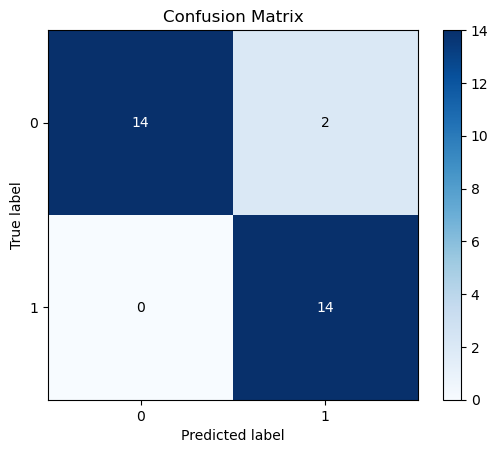

Accuracy: 93.33333333333333 %


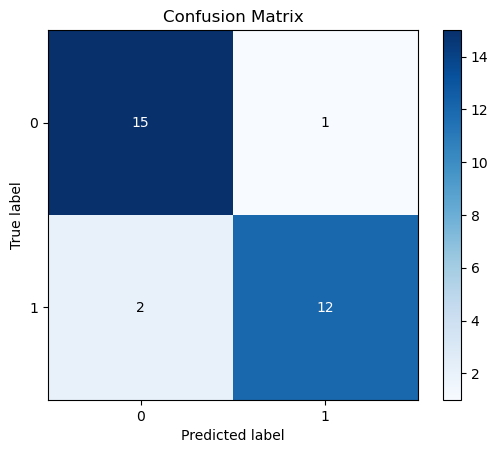

Accuracy: 90.0 %


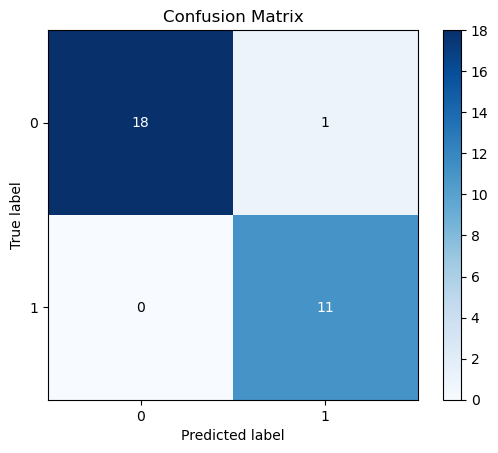

Accuracy: 96.66666666666667 %


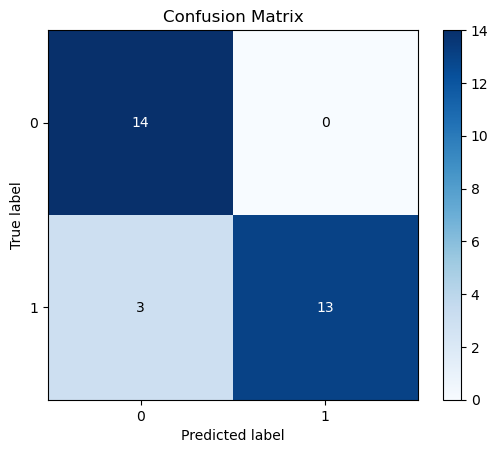

Accuracy: 90.0 %


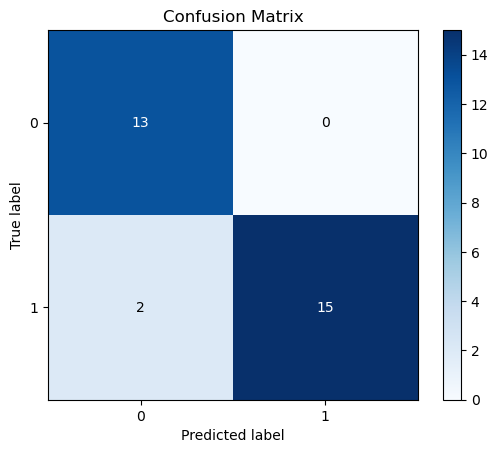

Accuracy: 93.33333333333333 %


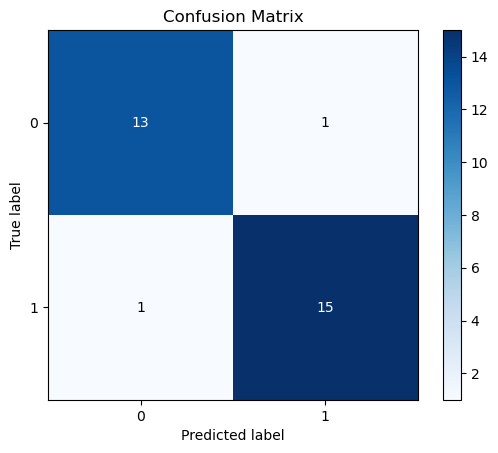

Accuracy: 93.33333333333333 %


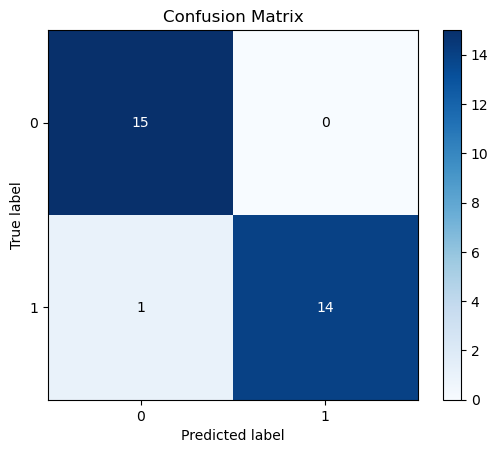

Accuracy: 96.66666666666667 %


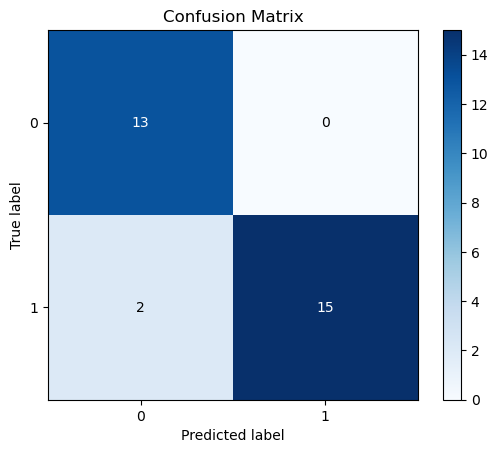

Accuracy: 93.33333333333333 %


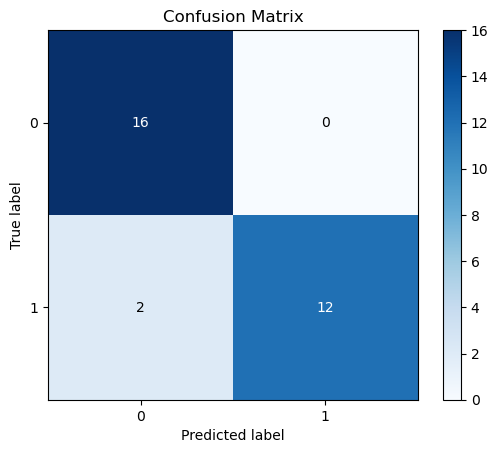

Accuracy: 93.33333333333333 %


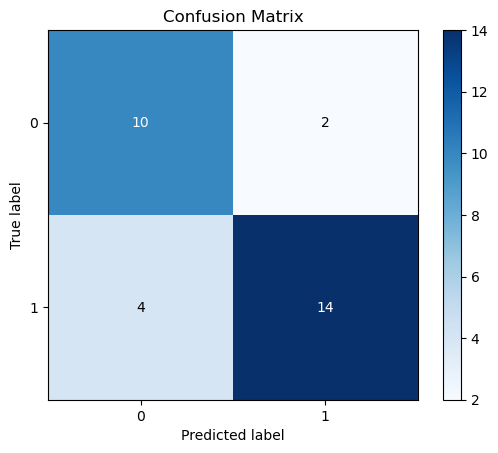

Accuracy: 80.0 %


In [64]:
# Define the K-fold Cross Validator
from sklearn.preprocessing import MinMaxScaler
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):

    #scaler = StandardScaler()  
    # Don't cheat - fit only on training data
    #scaler.fit(X)  
    scaler = MinMaxScaler()

# Fit scaler to data and transform data
    X=scaler.fit_transform(X)
    #X_train = scaler.transform(X_train)  
    # apply same transformation to test data
    #X_test = scaler.transform(X_test)  


    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200,),activation='logistic', learning_rate='constant', learning_rate_init=0.1, random_state=1, max_iter=3000, warm_start=True)
    clf.fit(X[train], y[train])
    # Evaluate the model
    y_pred=clf.predict(X[test])



    skplt.metrics.plot_confusion_matrix(y[test], y_pred)
    #skplt.metrics.plot_roc(y_test, predicted_probas)
    #skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas)
    plt.show()
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

In [65]:
mean_value = statistics.mean(acc_per_fold)
std_dev = statistics.stdev(acc_per_fold)
print("Mean using XGBoost:", mean_value)
print("Standard Deviation:", std_dev)

Mean using XGBoost: 92.0
Standard Deviation: 4.766135686561604


# Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
# Define the K-fold Cross Validator
num_folds=10
kfold = KFold(n_splits=num_folds, shuffle=True)

acc_per_fold=[]
fold_no = 1
for train, test in kfold.split(X, y):
    clfR=RandomForestClassifier(n_estimators=200,max_depth=10,bootstrap=True)

    # Train the model
    clfR.fit(X[train], y[train])
    # Evaluate the model
    y_pred=clfR.predict(X[test])
    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
    # Model Accuracy, how often is the classifier correct?
    acc=metrics.accuracy_score(y[test], y_pred)*100
    print("Accuracy:",acc,"%")
    acc_per_fold.append(acc)

      # Increase fold number
    fold_no = fold_no + 1

Accuracy: 93.33333333333333 %
Accuracy: 90.0 %
Accuracy: 90.0 %
Accuracy: 86.66666666666667 %
Accuracy: 96.66666666666667 %
Accuracy: 86.66666666666667 %
Accuracy: 90.0 %
Accuracy: 93.33333333333333 %
Accuracy: 80.0 %
Accuracy: 90.0 %


In [61]:
mean_value = statistics.mean(acc_per_fold)
std_dev = statistics.stdev(acc_per_fold)
print("Mean using XGBoost:", mean_value)
print("Standard Deviation:", std_dev)

Mean using XGBoost: 89.66666666666667
Standard Deviation: 4.567734398020992
